<a href="https://colab.research.google.com/github/lucasmartinso/IC/blob/main/pt2_Simula%C3%A7%C3%B5es_num%C3%A9ricas_3D_em_GPUs_de_hipertermia_com_nanopart%C3%ADculas_por_um_modelo_de_bioaquecimento_n%C3%A3o_linear_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Simulações numéricas 3D em GPUs de hipertermia com nanopartículas por um modelo de bioaquecimento não linear**

Nome: Lucas Martins Oliveira

# **Motivação**

Temos que o câncer de um modo geral é um problema de saúde mundial e afeta milhares de pessoas todos anos, dessa forma uma forma menos invasiva que vem sendo adotada são as terapias térmicas, já que essas vem apresentando ótimos resultados devido a sua  capacidade de aquecimento de diferentes tecidos e em áreas localizadas, assim temos vários “métodos”, como a terapia baseada em radiação eletromagnética, as baseadas em campos magnéticos alternados  de baixa frequência e a hipertermia por meio de nanopartículas que vai ser o nosso alvo de estudo

De um modo geral, a hipertermia com nanopartículas pode ser usada como um tratamento minimamente invasivo para destruir tumores em tecidos vivos.O objetivo é aquecer o tumor até um limiar de temperatura acima do fisiológico normal, a fim de destruir suas células por necrose,mantendo o mínimo possível o dano do tecido saudável, na qual esse tratamento não só destroi as celulas tumorais por conta do aquecimento provocado como também gera uma indução da resposta imune

Equação a ser modelada:

\begin{equation*}
  \begin{cases}
    \displaystyle \nabla \cdot k \nabla T + w_b c_b(T_a - T) + Q_m + Q_r = \rho c \frac{\partial T}{\partial t} \text{ para } \Omega\\\\
    \displaystyle k \nabla T \cdot\vec{n} = 0 \text{ para } \partial \Omega_{N_{B,C,D}}\\\\
    \displaystyle T  = 37 \text{ para } \partial \Omega_{D_A}\\\\
    \displaystyle T(.,0) = 37
  \end{cases}
\end{equation*}

\begin{equation*}
  \text { onde } T : \Omega \times  I \rightarrow \mathbb{R^+} \text { representa o campo de temperatura do tecido } \\
  p,c : \Omega \times  I \rightarrow \mathbb{R^+} \text { representa densidade  e o calor específico  do tecido, respectivamente } \\
  p_b, c_b : \Omega \times  I \rightarrow \mathbb{R^+} \text { representa densidade e o calor específico do sangue, respectivamente } \\
  k : \Omega \times  I \rightarrow \mathbb{R^+} \text { na qual a condutividade térmica é considerada isotrópica, mas não homogênea } \\
  w_b:  \Omega \times {R^+} \times  I \rightarrow \mathbb{R^+} \text { taxa de perfusão sanguínea } \\
  T_a \text {: temperatura arterial } \\
  Q_m : \Omega \times  I \rightarrow \mathbb{R^+} \text { representa a geração de calor metabólico } \\
  f : \Omega \times  I \rightarrow \mathbb{R^+} \text { temperatura prescrita(Dirichelet) ou fluxo (Neumann ou Robin)} \\
  \alpha , \beta : \Omega \times  I \rightarrow \mathbb{R^+} \text { sendo o vetor normal unitário } \\
  Q_r : \Omega \times  I \rightarrow \mathbb{R^+} \text { é o calor externo gerado pelas nanopartículas } \\
\end{equation*}

A discretização da primeira equação, através da aplicação do método das diferenças finitas de segunda ordem de 7 pontos:

\begin{equation*}
  \phi(T_{i,j}, T_{i \pm 1,j}, T_{i,j \pm 1}, T_{i,j \pm 1}) + (w(T)_{b_{i,j}})(p_{b_{i,j}})(c_{b_{i,j}})T_a + Q_{m_{i,j}} + Q_{r_{i,j}} = p_{i,j}c_{i,j}\frac{\partial T_{i,j}}{\partial t}
\end{equation*}

na qual temos:

\begin{equation*}
  T_{i,j} \approx T(x_i,y_j,t)
\end{equation*}

Na qual obtemos que:

\begin{equation*}
  \phi(T_{i,j}, T_{i \pm 1,j}, T_{i,j \pm 1}, T_{i,j \pm 1}) = \\
  \frac{1}{\Delta x^2}[k_{i+\frac{1}{2},j}(T_{i+1,j}-T_{i,j}) - k_{i-\frac{1}{2},j}(T_{i,j}-T_{i-1,j})] \\
  + \frac{1}{\Delta y^2}[k_{i,j+\frac{1}{2}}(T_{i,j+1}-T_{i,j}) - k_{i,j-\frac{1}{2}}(T_{i,j}-T_{i,j-1})] \\
   \\
  - w(T)_{b_{i,j}} (p_{b_{i,j}}) c_{b_{i,j}} T_{i,j} \\
\end{equation*}

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d, Axes3D
import numpy as np
import math

from google.colab import files
from matplotlib.figure import projections

plt.rcParams['figure.figsize'] = [8, 6]

In [ ]:
#n = (b-a)/h + 1 -> numero de pontos
#como temos que os dois pontos das extremidades já sao de dirichelet entao
#nn = (b-a)/h + 1 -2 -> numero de incognitas

h = 0.1/(101-1)
x = np.arange(0, 0.05+h/2, h)
y = np.arange(0, 0.1+h/2, h)

tam = len(x) #numero de incógnitas no eixo x
tamy = len(y) #numero de incógnitas no eixo x

#calor específico dp sangue
cb = 4200.0

#densidade do sangue
pb = 1000

A geração de calor metabólico varia de acordo com a região tratada, temos assim então:

\begin{equation*}
  Q_{m_{muscle}} = Q_{m_{fat}} = Q_{m_{dermis}} = 420.0 \\
  Q_{m_{tumor}} = 4200.0
\end{equation*}

In [ ]:
qm = np.zeros(4)

for i in range(4):
  '''
  qm[0] => qm_dermis
  qm[1] => qm_fat
  qm[2] => qm_muscle
  qm[3] => qm_tumor
  '''

  if(i==0 or i==1 or i==2) :
    qm[i] = 420.0
  else:
    qm[i] = 4200.0

Temos que a condutividade térmica varia de acordo com o tecido, assim obtemos a seguintes relações:

\begin{equation*}
  k_{dermis} = 0.40\\
  k_{fat} = 0.21\\
  k_{muscle} = 0.45\\
  k_{tumor} = 0.55\\
\end{equation*}

In [ ]:
k_term = np.zeros(4)

'''
  k_term[0] => k_term_dermis
  k_term[1] => k_term_fat
  k_term[2] => k_term_muscle
  k_term[3] => k_term_tumor
'''

k_term[0] = 0.4
k_term[1] = 0.21
k_term[2] = 0.45
k_term[3] = 0.55

A taxa de perfusão sanguínea varia de acordo com o tecido e com a temperatura que esse se encontra, dessa forma temos que:

\begin{equation*}
  W_{dermis} = 0.5 \\
  W_{muscle} =
    \begin{cases}
      \displaystyle 0.45 + 3.55exp(-\frac{(T-45.0)^2}{12.0}) \text { para } T \leq 45.0 \\\\
      4.0 \text { para } T>45.0
    \end{cases} \\
    W_{fat} =
    \begin{cases}
      \displaystyle 0.36 + 0.36exp(-\frac{(T-45.0)^2}{12.0}) \text { para } T \leq 45.0 \\\\
      0.72 \text { para } T>45.0
    \end{cases} \\
    W_{tumor} =
    \begin{cases}
      \displaystyle 0.833 + -\frac{(T-37.0)^{4.8}}{5.438E+3} \text { para } 37.0 \leq T \leq 42.0 \\\\
      0.416 \text { para } T>42.0
    \end{cases} \\
\end{equation*}

In [ ]:
def w_b(T) :
  '''
  w[0] => w_dermis
  w[1] => w_fat
  w[2] => w_muscle
  w[3] => w_tumor
  '''

  w_dermis = 0.5

  #w_muscle, w_fat, w_tumor -> definido pela condicao acima
  w_muscle = 4.0
  if(T<=45.0):
    w_muscle = 0.45 + 3.55*np.exp(-((T-45.0)**2)/12.0)

  w_fat = 0.72
  if(T<=45.0):
    w_fat = 0.36 + 0.36*np.exp(-((T-45.0)**2)/12.0)

  w_tumor = 0.416
  if(T<=42.0 and T>=37):
    w_tumor = 0.833 - (((T-37.0)**(4.8))/((5.438)*1000))

  return np.array([ w_dermis, w_fat, w_muscle, w_tumor ])

A densidade dos tecidos são diferentes uma das outras, dessa forma definimos para a mesma a seguinte variação:

\begin{equation*}
  \rho_{dermis} = 1200\\
  \rho_{fat} = 1000\\
  \rho_{muscle} = 1000\\
  \rho_{tumor} = 1000\\
\end{equation*}

In [ ]:
p = np.zeros(4)

'''
  p[0] => p_dermis
  p[1] => p_fat
  p[2] => p_muscle
  p[3] => p_tumor
'''

p[0] = 1200
p[1] = 1000
p[2] = 1000
p[3] = 1000

O calor específico dos tecidos são diferentes um dos outros, dessa forma definimos para a mesma a seguinte variação:

\begin{equation*}
  c_{dermis} = 3600\\
  c_{fat} = 2500\\
  c_{muscle} = 3800\\
  c_{tumor} = 4200\\
\end{equation*}

In [ ]:
c = np.zeros(4)

'''
  c[0] => c_dermis
  c[1] => c_fat
  c[2] => c_muscle
  c[3] => c_tumor
'''

c[0] = 3600
c[1] = 2500
c[2] = 3800
c[3] = 4200

Assim para modelarmos de acordo com a matriz solução que temos, modelamos as regiões do espaço, aonde é tumor, músculo, derme, gordura

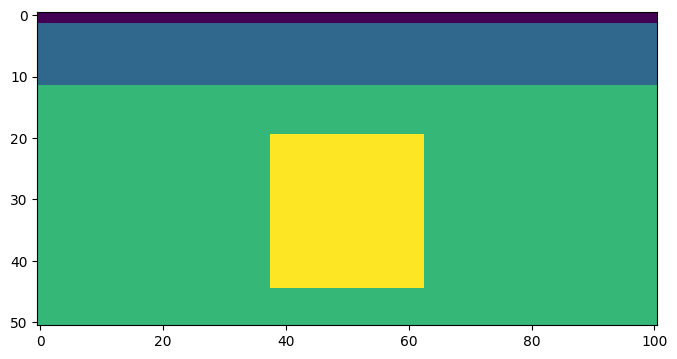

In [ ]:
#matriz de 51x101
#matriz indica qual tecido se trata
tp = np.zeros((len(x),len(y)))

for i in range(len(x)):
  for j in range(len(y)):
    '''
    tp[i][j] = 0 -> dermis
    tp[i][j] = 1 -> fat
    tp[i][j] = 2 -> muscle
    tp[i][j] = 3 -> tumor
    '''

    if((i>(12+20-13) and i<(12+20+13) and j>(50-13) and j<(50+13))):
      #tumor esfera de raio 13mm
      #centro (20,50)mm
      tp[i][j] = 3
    elif(i<2) :
      #derme 2mm
      tp[i,j] = 0
    elif(i<12) :
      #adiposo 10mm
      tp[i,j] = 1
    else :
      #muscular 38mm
      tp[i,j] = 2

np.savetxt("k",np.transpose(tp), fmt='%d')
plt.imshow(tp)

Temos que o calor gerado pelas nanopartículas vai ser definido pela seguinte expressão:

\begin{equation*}
  Q_r = \sum_{i=1}^{n} A_{i} 𝐞^{-r^2_{i,j}/{r^2_0}}
\end{equation*}

\begin{equation*}
  \text{ r é a distância do local da injeção}\\
  r_0 \text{ é a distância  percorrida pelo calor gerado pelas nanopartículas } \\
  A \text{ é a força máxima da taxa volumétrica de geração de calor } \\
  n \text{ é o número total de pontos de injeção (locais) }
\end{equation*}

No qual, no artigo são considerados três pontos de injeções, nesses 3 pontos a força volumetrica considerada(A) e a distância percorrida pela injeção foi(r0), foram de:

Considerando as respectivas posições de aplicação:

\begin{equation*}
  \text { Posição: } \\
  1: (0.020, 0.055, 0.055) \\
  2: (0.025, 0.045, 0.045) \\
  3: (0.015, 0.040, 0.040) \\
\end{equation*}

\begin{equation*}
  A_1 = 0,8 \times 10^6 W/m^3 \\
  A_2 = 0,7 \times 10^6 W/m^3 \\
  A_3 = 0,7 \times 10^6 W/m^3 \\
\end{equation*}

\begin{equation*}
  r_{0} = 3,1 \times 10^{-3} W/m^3 \\
\end{equation*}


In [ ]:
num_inj = 3
qr = np.zeros((len(x),len(y)))
r = np.zeros((len(x),len(y),num_inj))
A = np.zeros(num_inj)
r0 = 3.1 * 10**(-3) #de onde ate onde o calor se espalha

A[0] = 0.8 * 10**(6)
A[1] = 0.7 * 10**(6)
A[2] = 0.7 * 10**(6)

inj_x = np.zeros(num_inj)
inj_y = np.zeros(num_inj)

#injecao 1 -> (20,55)
inj_x[0] = 20
inj_y[0] = 55

#injecao 2 -> (25,45)
inj_x[1] = 25
inj_y[1] = 45

#injecao 3 -> (15,40)
inj_x[2] = 15
inj_y[2] = 40

for i in range(len(x)) :
  for j in range(len(y)) :
    for k in range(num_inj) :
      dist = (np.sqrt((inj_x[k]*h - i*h)**2 + (inj_y[k]*h -j*h)**2))
      r[i,j,k] = dist

for i in range(len(x)):
  for j in range(len(y)):
    for k in range(num_inj) :
      qr[i,j] += A[k]*(np.exp((-(r[i,j,k]**2))/(r0**2)))

Assim temos que a condutividade térmica, pode ser calculada usando o método do ponto do médio, então:
\begin{equation*}
  k_{i+\frac{1}{2},j} \approx \frac{2k_{i,j}k_{i+1,j}}{k_{i,j}+k_{i+1,j}}
\end{equation*}

In [ ]:
#buscar o tipo: derme, musculo, gordura, tumor
def busca(i,j):
  return tp[i][j]

#definicao de k_i+1/2,j ou k_i,j+1/2 obtido atraves da media
def k_meio(i,j,ind,sinal) :
  '''
  ind -> 0 -> i
  ind -> 1 -> j,
  '''

  '''
  sinal -> True -> +1
  sinal -> False -> -1,
  '''

  #buscar o tipo derme, musculo, gordura, tumor
  ktp1 = int(busca(i,j))
  ktp2 = int(busca(i,j))

  #tratar fronteira
  if(ind==0 and i==50 and sinal==True):
    return (2*k_term[ktp1]*k_term[ktp2])/(k_term[ktp1]+k_term[ktp2])

  elif(ind==0 and i==0 and sinal==False):
    return (2*k_term[ktp1]*k_term[ktp2])/(k_term[ktp1]+k_term[ktp2])

  elif(ind==1 and j==100 and sinal==True):
    return (2*k_term[ktp1]*k_term[ktp2])/(k_term[ktp1]+k_term[ktp2])

  elif(ind==1 and j==0 and sinal==False):
    return (2*k_term[ktp1]*k_term[ktp2])/(k_term[ktp1]+k_term[ktp2])

  elif(ind==0 and sinal==True) :
    ktp2 = int(busca(i+1,j))
    return (2*k_term[ktp1]*k_term[ktp2])/(k_term[ktp1]+k_term[ktp2])

  elif(ind==0 and sinal==False) :
    ktp2 = int(busca(i-1,j))
    return (2*k_term[ktp1]*k_term[ktp2])/(k_term[ktp1]+k_term[ktp2])

  elif(ind==1 and sinal==True) :
    ktp2 = int(busca(i,j+1))
    return (2*k_term[ktp1]*k_term[ktp2])/(k_term[ktp1]+k_term[ktp2])

  elif(ind==1 and sinal==False) :
    ktp2 = int(busca(i,j-1))
    return (2*k_term[ktp1]*k_term[ktp2])/(k_term[ktp1]+k_term[ktp2])

A variação do tempo vai ser expressa da seguinte forma:

\begin{equation*}
  \Delta t(\frac{\alpha}{\Delta x^2} + \frac{\alpha}{\Delta y^2} + \frac{\beta}{4}) \leq \frac{1}{2}
\end{equation*}

\begin{equation*}
  \text {onde } \alpha = \frac{ \kappa_{i,j}}{ (\rho_{i,j} c)} \\
  \beta = \frac{w_{b_{i,j}}p_{b_{i,j}}c_b}{ (\rho_{i,j} c_{i,j})} \\
  \Delta x^2 = \Delta y^2 = h^2
\end{equation*}

Dessa forma a equação inicial fica organizada da seguinte maneira:

\begin{equation*}
  \Delta t \leq \frac{2h^2}{4 \alpha + \beta h^2}
\end{equation*}

Implementação através do método de Euler parabólico:

Dado que temos o seguinte problema:

\begin{equation*}
  \nabla \cdot k \nabla T + w_b c_b(T_a - T) + Q_m + Q_r = \rho c \frac{\partial T}{\partial t} \\
\end{equation*}

Reorganizando a:

\begin{equation*}
  \frac{ \frac{\partial k  T}{\partial^2t } + w_b c_b(T_a - T) + Q_m + Q_r}{\rho c} =  \frac{\partial T}{\partial t} \\
\end{equation*}

Temos que:

\begin{equation*}
  \frac{\partial{T}}{\partial{t}} \approx \frac{T^{n+1}_{i,j} - T^n_{i,j}}{h_t} \\
  \nabla \cdot k \nabla T \approx \frac{-k_{i+ \frac{1}{2},j}(T_{i,j} - T_{i+1,j}) + k_{i- \frac{1}{2},j}(T_{i-1,j} - T_{i,j}) - k_{i,j+ \frac{1}{2}}(T_{i,j} - T_{i,j+1}) + k_{i,j- \frac{1}{2}}(T_{i,j-1} - T_{i,j})}{h^2} \\
\end{equation*}

Organizando e aglutinando a expressão, temos:

\begin{equation*}
  T^{n+1}_{i,j} = T^n_{i,j} + \frac{r}{h^2}(-T^n_{i,j}(k_{i+ \frac{1}{2},j} + k_{i- \frac{1}{2},j} + k_{i,j+ \frac{1}{2}} + k_{i,j- \frac{1}{2}}) + k_{i+ \frac{1}{2},j}T^n_{i+1,j} + k_{i- \frac{1}{2},j}T^n_{i-1,j} + k_{i,j+ \frac{1}{2}}T^n_{i,j+1} + k_{i,j- \frac{1}{2}}T^n_{i,j-1}) -r c_b w_{b_{i,j}}(T_a -T^n_{i,j}) + r(q_{r_{i,j}} + q_{m_{i,j}}) \\
\end{equation*}

Onde r é:

\begin{equation*}
  r = \frac{h_t}{pc}
\end{equation*}

In [ ]:
h_t=0.1

t = np.arange(0,1000+h_t/2, h_t)

#Condicoes de Contorno
u_a = 37 #dirichelet esquerdo -> T0
u_b = 0 #neumann topo
u_c = 0 #neumann direito
u_d = 0 #neumann base
u_0 = 37 #condicao inicial

#vetor solução
u=np.ones((len(x),len(y)))*u_0
u_new=np.ones((len(x),len(y)))*u_0

steps = len(t) #numero de passos de tempo

Ta = 37.0

sol_tempo = []
sol_tempo.append(u)
from tqdm import tqdm


for k in tqdm(range(steps)):
  for i in range(len(x)):
    for j in range(len(y)):
      #TODAS AS RELAÇÕES COM PONTOS FICTICIOS
      # uijp = 2*h*u_c+u[i,len(y)-1] if j==len(y)-1 else u[i,j+1]
      # uijm = 2*h*u_a+u[i,1] if j==0 else u[i,j-1]
      # uipj = 2*h*u_d+u[tam-1,j] if i==tam-1 else u[i+1,j]
      # uimj = 2*h*u_b+u[1,j] if i==0 else u[i-1,j]

      k_ip = k_meio(i,j,0,True) #ki+1/2
      k_im = k_meio(i,j,0,False) #ki-1/2
      k_jp = k_meio(i,j,1,True) #ki,j+1/2
      k_jm = k_meio(i,j,1,False) #ki,j-1/2
      #k_ip = k_im = k_jp = k_jm = 0.5

      #para tratar do tipo Dirichlet, devemos atribuir diretamente no ponto (x_i,y_j)
      if (i==0):
        u_new[i,j] = u_a
      else:
        #Tradando condicoes de contorno do tipo Neumann
        uijp = 2*h*u_c+u[i,len(y)-2] if j==len(y)-1 else u[i,j+1]
        uimj =  u[i-1,j]
        uipj = 2*h*u_d+u[tam-2,j] if i==tam-1 else u[i+1,j]
        uijm = 2*h*u_b+u[i,1] if j==0 else u[i,j-1]

        r = (h_t/(p[int(busca(i,j))] * c[int(busca(i,j))]))

        u_new[i,j] = u[i,j] + (r/(h**2))*(-u[i,j]*(k_ip + k_im + k_jp + k_jm) +(k_im*uimj + k_ip*uipj + k_jm*uijm + k_jp*uijp)) + r*cb*w_b(u[i,j])[int(busca(i,j))]*(Ta - u[i,j]) + ((r)*(qm[int(busca(i,j))]+qr[i,j]))
    u = np.copy(u_new)
    if(k % 100 == 0) :
      sol_tempo.append(u)

print(u)

100%|██████████| 6/6 [00:01<00:00,  3.33it/s]


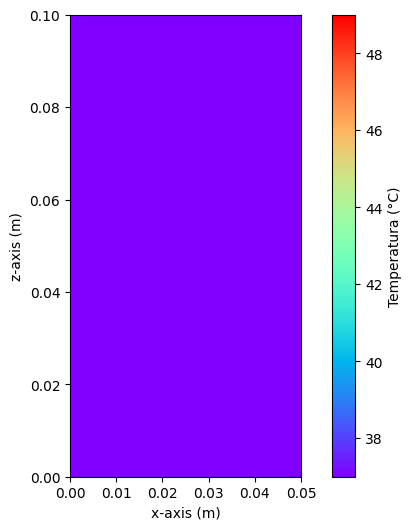

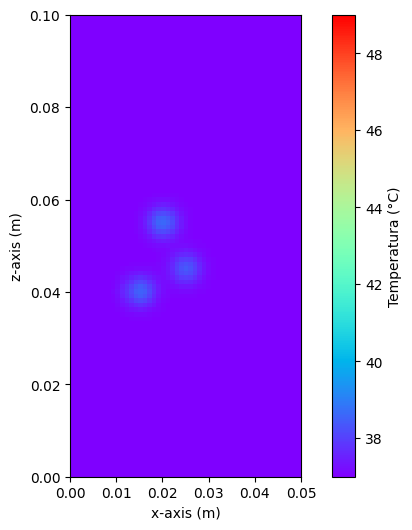

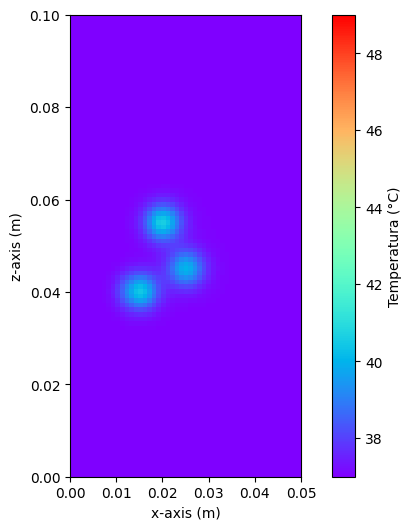

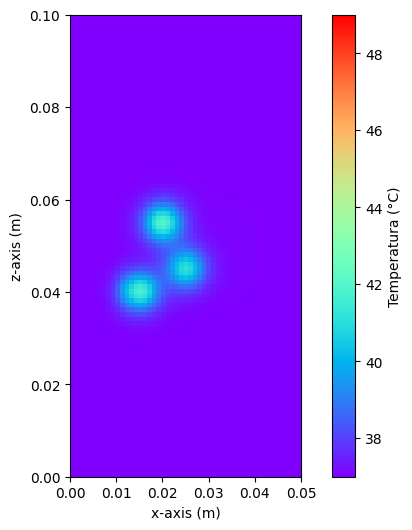

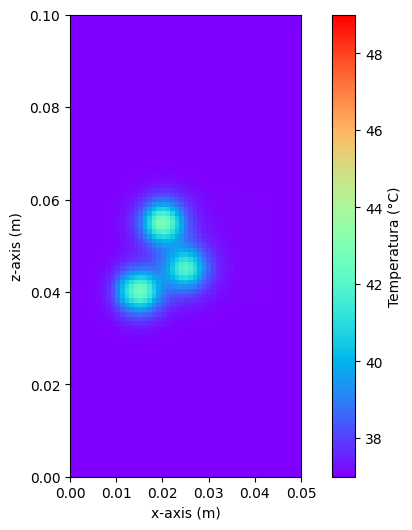

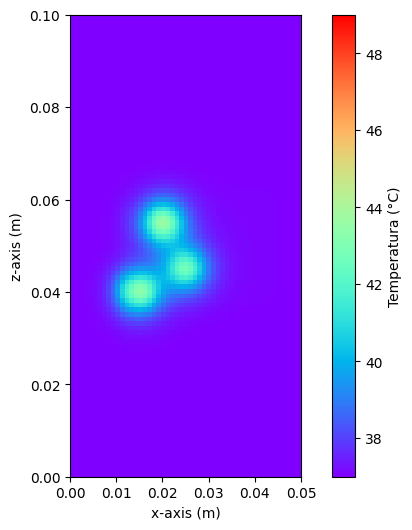

In [ ]:
it=100

for k in tqdm(range(0,len(sol_tempo), it)):
  #plt.plot(x,sol_tempo[k], label='t='+"{:.2f}".format(k*h_t))
  fig = plt.figure()
  plt.xlabel('x-axis (m)')
  plt.ylabel('Temperatura (°C)')
  plt.ylabel('z-axis (m)')
  plt.imshow(np.transpose(sol_tempo[k]), vmin = 37.0 , vmax = 49.0, cmap = 'rainbow', interpolation = 'nearest', origin = 'lower', extent=[0,0.05,0,0.1]) #u[len(x)-1][len(y)-1]
  plt.colorbar(label = 'Temperatura (°C)')

  grafics = "calor" + str(k) + ".png"
  plt.savefig(grafics, dpi=96)
plt.show()
